In [1]:
import numpy as np
import tensorflow as tf
tf.random.set_seed(1234)
import matplotlib.pyplot as plt
import cv2

In [2]:
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.callbacks import Callback, LearningRateScheduler, TensorBoard, ModelCheckpoint

In [3]:
IMG_SIZE = 32

In [4]:
tf.__version__

'2.4.0-dev20200701'

In [5]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [6]:
# Assemble dataset
def get_matrices():
    
    (x_tr, y_tr), (x_te, y_te) = load_batch(999, test=True)
    x_te, y_te = preprocess(x_te, y_te)
    x_tr, y_tr = preprocess(x_tr, y_tr)
    
    print('x_tr shape: '+ str(x_tr.shape))
    print('y_tr shape: '+ str(y_tr.shape))
    print('\nx_tr dtype: '+ str(x_tr.dtype))
    print('y_tr dtype: '+ str(y_tr.dtype))
    print('\nx_te shape: '+ str(x_te.shape))
    print('y_te shape: '+ str(y_te.shape))
    print('\nx_te dtype: '+ str(x_te.dtype))
    print('y_te dtype: '+ str(y_te.dtype))  
    
    return x_tr, y_tr, x_te, y_te
    
# Load dataset from memory
def load_batch(i, test = False):
    return tf.keras.datasets.cifar100.load_data()

In [7]:
# Pre-process functions here 

# Assemble pre-processes
def preprocess(x, y):
    
    # ohe
    y = OneHotEncoder().fit_transform(np.array(y).reshape(-1,1)).toarray()
        
    # as float16
    x = x.astype('float64')
    y = y.astype('float64')
    
    # normalize
    min_val = np.min(x)
    max_val = np.max(x)
    x = (x-min_val) / (max_val-min_val)
    
    return x, y

In [8]:
# Common functions
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def plot_history(hist):
    fig=plt.figure()
    ax=fig.add_subplot(121)
    bx=fig.add_subplot(122)
    ax.plot(hist.history['loss'],label='loss')
    ax.plot(hist.history['val_loss'],label='val_loss')
    ax.set_title('loss')
    ax.legend()
    bx.plot(hist.history['accuracy'],label='accuracy')
    bx.plot(hist.history['val_accuracy'],label='val_accuracy')
    bx.set_title('accuracy')
    bx.legend()

In [9]:
x_tr, y_tr, x_te, y_te = get_matrices()

x_tr shape: (50000, 32, 32, 3)
y_tr shape: (50000, 100)

x_tr dtype: float64
y_tr dtype: float64

x_te shape: (10000, 32, 32, 3)
y_te shape: (10000, 100)

x_te dtype: float64
y_te dtype: float64


Text(0.5, 1.0, '88')

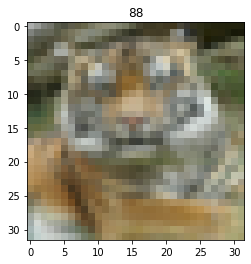

In [10]:
ind = np.random.randint(0,10000)
plt.imshow((255*x_te[ind]).astype('int'))
plt .title(y_te[ind].argmax())

### Callbacks

In [11]:
class SaveLosseAndMetrics(tf.keras.callbacks.Callback):
    
    def __init__(self, batch_interval=5):
        super(SaveLosseAndMetrics, self).__init__()
        self.batch_interval = batch_interval
        self.record = {}
        self.keys = ['loss']
    
    def on_train_begin(self, logs=None):
        self.keys += self.model.metrics_names
        
        for key in self.keys:
            if key not in self.record.keys():
                self.record[key] = []
            
    def on_train_batch_end(self, batch, logs=None):

        if batch % self.batch_interval:
            for key in self.keys:
                self.record[key].append(logs[key])

In [12]:
class LRScheduler(tf.keras.callbacks.Callback):
    
    def __init__(self):
        
        self.schedule = []
        self.batches = None
    
    def on_epoch_end(self, epoch, logs=None):
        #schedule here for lr of each batch 
        self.model.optimizer.lr = self.model.optimizer.lr * (10**-0.2)

#     def on_train_batch_begin(self, batch, logs=None):
#         pass
       

In [13]:
class SaveBestModel(tf.keras.callbacks.Callback):
    
    def __init__(self):
        super(SaveBestModel, self).__init__()
        
        self.paratha = []
    
    def on_train_batch_end(self, batch, logs=None):
        keys = list(logs.keys())
        self.paratha.append(logs['loss'])

In [14]:
model.stop_training

NameError: name 'model' is not defined

### Attempt 1

In [19]:
class FeatureBlock2(tf.keras.Model):

    def __init__(self):
        super(FeatureBlock2, self).__init__()
        
        # Block 1
        self.c11  = tf.keras.layers.Conv2D(35, (3,3))
        self.c12  = tf.keras.layers.Conv2D(40, (3,3))
        self.m11 = tf.keras.layers.MaxPool2D()
        self.c13  = tf.keras.layers.Conv2D(40, (1,1))
        
        # Block 2
        self.c21 = tf.keras.layers.Conv2D(40, (3,3))
        self.c22 = tf.keras.layers.Conv2D(40, (3,3))
        self.m21 = tf.keras.layers.MaxPool2D()
        self.c23  = tf.keras.layers.Conv2D(50, (1,1))

    def call(self, inputs):
        
        # Block 1
        x1 = self.c11(inputs)
        x1 = self.c12(x1)
        x1 = self.m11(x1)
        x1 = self.c13(x1)
        
        # Block 2
        x2 = tf.keras.layers.ZeroPadding2D(padding=1)(x1)
        x2 = self.c21(x2)
        x2 = tf.keras.layers.ZeroPadding2D(padding=1)(x2)
        x2 = self.c22(x2)     
        x2 = self.m21(x2)
        x2 = self.c23(x2)
        
        return x2

class DenseBlock2(tf.keras.Model):

    def __init__(self):
        super(DenseBlock2, self).__init__()
        
        self.f31 = tf.keras.layers.Flatten()
        self.d31 = tf.keras.layers.Dense(146, activation= tf.keras.activations.relu)
        self.d32 = tf.keras.layers.Dense(100, activation= tf.keras.activations.softmax)

    def call(self, inputs):
        
        x1 = self.f31(inputs)
        x1 = self.d31(x1)
        x1 = self.d32(x1)
        #x3 = tf.clip_by_value(x3, 1e-2, 1)
        
        return x1

class BasicModel2(tf.keras.Model):

    def __init__(self):
        super(BasicModel2, self).__init__()
        
        self.model_name = "Basic"
        
        self.feature_block = FeatureBlock2()
        
        self.dense_block = DenseBlock2()

    def call(self, inputs):
        
        x1 = self.feature_block(inputs)
        x2 = self.dense_block(x1)
        
        return x2

In [ ]:
model = BasicModel2()
optimizer=tf.keras.optimizers.Adam(learning_rate=3e-3)
loss=tf.keras.losses.CategoricalCrossentropy()
cb1 = SaveLosseAndMetrics()
model.compile(optimizer,loss,metrics=['accuracy'])
model.build((None, IMG_SIZE, IMG_SIZE, 3))
model.summary()

In [ ]:
hist = model.fit(x_tr, y_tr, epochs= 1
                 , validation_data= (x_te, y_te), callbacks=[cb1,LongTermTrainer()])

In [ ]:
plt.plot(moving_average(cb1.record['loss'],n=40))
plt.plot(moving_average(cb1.record['loss'],n=300))

In [15]:
plot_history(hist)

NameError: name 'hist' is not defined

### Attempt 2

In [16]:
BATCH_SIZE = 100
NUM_CLASSES = 100
EPOCHS = 30
INIT_DROPOUT_RATE = 0.5
MOMENTUM_RATE = 0.9
INIT_LEARNING_RATE = 0.5
L2_DECAY_RATE = 0.0005
CROP_SIZE = 32
MODEL_PATH = './models/'
LOG_PATH = './logs'

In [17]:
class FeatureBlock2(tf.keras.Model):

    def __init__(self):
        super(FeatureBlock2, self).__init__()
        
        # Block 1
        self.c11  = tf.keras.layers.Conv2D(96, 
                                           (3,3), 
                                           padding='same', 
                                           kernel_regularizer=tf.keras.regularizers.l2(L2_DECAY_RATE), 
                                           activation = tf.keras.activations.elu)
        self.c12  = tf.keras.layers.Conv2D(96, 
                                           (3,3), 
                                           padding='same', 
                                           kernel_regularizer=tf.keras.regularizers.l2(L2_DECAY_RATE), 
                                           activation = tf.keras.activations.elu)
        self.m11 = tf.keras.layers.MaxPool2D(pool_size=(2,2), padding='same')
        self.dr11 = tf.keras.layers.Dropout(INIT_DROPOUT_RATE)
        
        # Block 2
        self.c21  = tf.keras.layers.Conv2D(96, 
                                           (1,1), 
                                           padding='same', 
                                           kernel_regularizer=tf.keras.regularizers.l2(L2_DECAY_RATE), 
                                           activation = tf.keras.activations.elu)
        self.c22  = tf.keras.layers.Conv2D(96, 
                                           (2,2), 
                                           padding='same', 
                                           kernel_regularizer=tf.keras.regularizers.l2(L2_DECAY_RATE), 
                                           activation = tf.keras.activations.elu)
        self.c23  = tf.keras.layers.Conv2D(96, 
                                           (2,2), 
                                           padding='same', 
                                           kernel_regularizer=tf.keras.regularizers.l2(L2_DECAY_RATE), 
                                           activation = tf.keras.activations.elu)
        self.m21 = tf.keras.layers.MaxPool2D(pool_size=(2,2), padding='same')
        self.dr21 = tf.keras.layers.Dropout(INIT_DROPOUT_RATE)
        
        # Block 3
        self.c31  = tf.keras.layers.Conv2D(168, 
                                           (1,1), 
                                           padding='same', 
                                           kernel_regularizer=tf.keras.regularizers.l2(L2_DECAY_RATE), 
                                           activation = tf.keras.activations.elu)
        self.c32  = tf.keras.layers.Conv2D(168, 
                                           (2,2), 
                                           padding='same', 
                                           kernel_regularizer=tf.keras.regularizers.l2(L2_DECAY_RATE), 
                                           activation = tf.keras.activations.elu)
        self.c33  = tf.keras.layers.Conv2D(168, 
                                           (2,2), 
                                           padding='same', 
                                           kernel_regularizer=tf.keras.regularizers.l2(L2_DECAY_RATE), 
                                           activation = tf.keras.activations.elu)
        self.m31 = tf.keras.layers.MaxPool2D(pool_size=(2,2), padding='same')
        self.dr31 = tf.keras.layers.Dropout(INIT_DROPOUT_RATE)
        
        # Block 4 
        self.c41  = tf.keras.layers.Conv2D(168, 
                                           (1,1), 
                                           padding='same', 
                                           kernel_regularizer=tf.keras.regularizers.l2(L2_DECAY_RATE), 
                                           activation = tf.keras.activations.elu)
        self.c42  = tf.keras.layers.Conv2D(168, 
                                           (2,2), 
                                           padding='same', 
                                           kernel_regularizer=tf.keras.regularizers.l2(L2_DECAY_RATE), 
                                           activation = tf.keras.activations.elu)
        self.c43  = tf.keras.layers.Conv2D(168, 
                                           (2,2), 
                                           padding='same', 
                                           kernel_regularizer=tf.keras.regularizers.l2(L2_DECAY_RATE), 
                                           activation = tf.keras.activations.elu)
        self.m41 = tf.keras.layers.MaxPool2D(pool_size=(2,2), padding='same')
        self.dr41 = tf.keras.layers.Dropout(INIT_DROPOUT_RATE)
        
    def call(self, inputs):
        
        # Block 1
        x1 = self.c11(inputs)
        x1 = self.c12(x1)
        x1 = self.m11(x1)
        #x1 = self.dr11(x1)
        
        # Block 2
        x2 = self.c21(x1)
        x2 = self.c22(x2)
        x2 = self.c23(x2)
        x2 = self.m21(x2)
        #x2 = self.dr21(x2)
        
        # Block 3
        x3 = self.c31(x2)
        x3 = self.c32(x3)
        x3 = self.c33(x3)
        x3 = self.m31(x3)
        #x3 = self.dr31(x3)
        
        # Block 4
        x4 = self.c41(x3)
        x4 = self.c42(x4)
        x4 = self.c43(x4)
        x4 = self.m41(x4)
        #x4 = self.dr41(x4)
        
        return x4

class DenseBlock2(tf.keras.Model):

    def __init__(self):
        super(DenseBlock2, self).__init__()
        
        self.f31 = tf.keras.layers.Flatten()
        self.d31 = tf.keras.layers.Dense(200, activation= tf.keras.activations.relu)
        self.d32 = tf.keras.layers.Dense(100, activation= tf.keras.activations.softmax)

    def call(self, inputs):
        
        x1 = self.f31(inputs)
        x1 = self.d31(x1)
        x1 = self.d32(x1)
        
        return x1

class BasicModel2(tf.keras.Model):

    def __init__(self):
        super(BasicModel2, self).__init__()
        
        self.feature_block = FeatureBlock2()
        self.dense_block = DenseBlock2()

    def call(self, inputs):
        
        x1 = self.feature_block(inputs)
        x2 = self.dense_block(x1)
        
        return x2

In [20]:
model = BasicModel2()
optimizer=tf.keras.optimizers.SGD(lr=INIT_LEARNING_RATE, momentum=MOMENTUM_RATE)
loss=tf.keras.losses.CategoricalCrossentropy()
cb1 = SaveLosseAndMetrics()
cb2 = LRScheduler()
cb3 = tf.keras.callbacks.ModelCheckpoint(MODEL_PATH, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
cb4 = tf.keras.callbacks.TensorBoard(log_dir=LOG_PATH, batch_size=BATCH_SIZE)
model.compile(optimizer,loss,metrics=['accuracy'])
model.build((None, IMG_SIZE, IMG_SIZE, 3))
model.summary()

Model: "basic_model2_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_block2_1 (FeatureBlo multiple                  46190     
_________________________________________________________________
dense_block2_1 (DenseBlock2) multiple                  372546    
Total params: 418,736
Trainable params: 418,736
Non-trainable params: 0
_________________________________________________________________


In [41]:
hist = model.fit(x_tr
                 ,y_tr, epochs= 1
                 , validation_data= (x_te, y_te), callbacks=[cb1,cb3, LongTermTrainer()])

Starting to train new model
1563/1563 [==============================] - ETA: 0s - loss: nan - accuracy: 0.0100
Epoch 00001: val_loss did not improve from inf
Saving weights...

AttributeError: 'LongTermTrainer' object has no attribute 'save_weights'

In [21]:
model.save_weights('./../checkpoints/try',)

In [32]:
import os
os.getcwd()
os.listdir(path='/home/mobiliser/Desktop/')
import re

mylist = ["dog", "cat", "wildcat", "thundercat", "cow", "hooo"]
r = re.compile(".*cat")
newlist = list(filter(r.match, mylist)) # Read Note
print(newlist)

list(map(int, ['1', '2']))

['cat', 'wildcat', 'thundercat']


[1, 2]

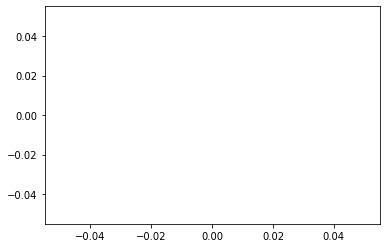

In [20]:
plt.plot(moving_average(cb1.record['loss'],n=40))
plt.plot(moving_average(cb1.record['loss'],n=300))

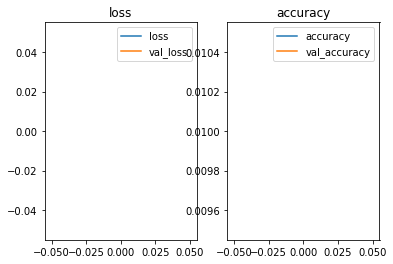

In [21]:
plot_history(hist)

In [25]:
model.optimizer.lr = 0.9999

In [26]:
model.optimizer.lr

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.9999>